# Prepare Mean and std for significance analysis


What do I want to investigate?

- Is this behaviour significantly different to the field over all?
1. compute mean over historical period per location over all members
2. compute standard deviation per member
3. store field

- Do all members show the same behaviour?
1. compute mean over event period (the entire period? only period 1? only period 2?) per location over all event members
2. compute standard deviation per member
3. store field

In [7]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools            # to mask region of interest
import gsw                  # compute potential density

1. open file

2. compute mean per location over time

3. store field

4. compute standard deviation between all members per location

5. compute standard deviation between all members per location

6. save field

# Mean and std over historical period

In [4]:
# set up regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 
                             'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

# set time range to historical period
hist_period = (2014-1850)*12
time = slice(0, hist_period)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [32]:
variables = ['temp','salt','vvel','shf','ssh','hmxl'] #, uvel,'aice','rho','n_heat','psl']
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'

In [33]:
for var in variables:
    
    print(var)
    print('')
    
    files = sorted(glob.glob(path + var + '/*.nc'))

    ds_collect = []
    uppercase_var = var.upper()

    # open file
    for i in range(2):
        ds = xr.open_dataset(files[i]).isel(time=slice(0,3))
        ds = ds[uppercase_var].where(mask3d == 1)
        #if var in ('temp', 'salt', 'vvel'):
        #    ds = ds.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t')

        # compute mean per location over time
        ds = ds.mean('time')

        # store
        ds_collect.append(ds)

    stacked_fields = xr.concat(ds_collect, dim='fields')    

    # compute mean between all members per location
    mean_values = stacked_fields.mean(dim='fields')

    # compute standard deviation between all members per location
    std_values = stacked_fields.std(dim='fields')

    # save field
    # Create a new dataset to store the mean and standard deviation values together
    combined_dataset = xr.Dataset({'mean_values': mean_values, 'std_values': std_values})

    # Save the dataset to a NetCDF file
    combined_dataset.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/'+var+'mean_std_values.nc')
    
    print(var + ' completed')

temp

temp completed
salt

salt completed
vvel

vvel completed
shf

shf completed
ssh

ssh completed
hmxl

hmxl completed


In [3]:
test = xr.open_dataset(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/temp_mean_std.nc')

In [4]:
test.mean_values.isel(z_t=0).plot()

<xarray.Dataset>
Dimensions:      (z_t: 60, nlat: 384, nlon: 320)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG        (nlat, nlon) float64 ...
    ULAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    mean_values  (z_t, nlat, nlon) float32 ...
    std_values   (z_t, nlat, nlon) float32 ...

# Compute density significance

In [25]:
# set up regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7, 9]}, 'bounds': {'TLAT': [20., 78.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}]} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

# set time range to historical period
hist_period = (2014-1850)*12
time = slice(0, hist_period)

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'

var = 'temp'
ds_collect = []
files = sorted(glob.glob(path + var + '/*.nc'))
# open file
for i in range(2):#len(files)):
    ds = xr.open_dataset(files[i]).isel(time=slice(0,3))#time)
    ds = ds.where(mask3d == 1)
        # compute mean per location over time
    ds = ds.mean('time')
    ds_collect.append(ds)
stacked_temp = xr.concat(ds_collect, dim='fields')    

var = 'salt'
ds_collect = []
files = sorted(glob.glob(path + var + '/*.nc'))
# open file
for i in range(2):#len(files)):
    ds = xr.open_dataset(files[i]).isel(time=slice(0,3))#time)
    ds = ds.where(mask3d == 1)
        # compute mean per location over time
    ds = ds.mean('time')
    ds_collect.append(ds)
stacked_salt = xr.concat(ds_collect, dim='fields')   

In [27]:
# Create final array
stacked_temp = stacked_temp.update(stacked_salt[["SALT"]])

# Compute potential density
CT = gsw.conversions.CT_from_pt(stacked_temp.SALT, stacked_temp.TEMP)
stacked_temp['SIGMA_2'] = gsw.density.sigma2(stacked_temp.SALT, CT)

In [28]:
# compute mean between all members per location
mean_values = stacked_temp['SIGMA_2'].mean(dim='fields')

# compute standard deviation between all members per location
std_values = stacked_temp['SIGMA_2'].std(dim='fields')

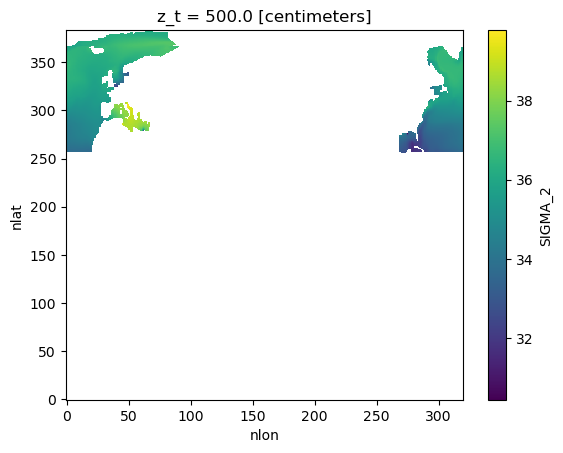

In [29]:
mean_values.isel(z_t=0).plot()

do PSL

In [34]:
var = 'psl'
    
print('')
print(var+ ' started')
print('')

files = sorted(glob.glob(path + var + '/*.nc'))

ds_collect = []
uppercase_var = var.upper()

# open file
for i in range(3):#len(files)):
    ds = xr.open_dataset(files[i]).isel(time=slice(0,3))#time)
    ds = ds.PSL.mean('time')

    ds_collect.append(ds)

stacked_fields = xr.concat(ds_collect, dim='fields')    

# compute mean between all members per location
mean_values = stacked_fields.mean(dim='fields')

# compute standard deviation between all members per location
std_values = stacked_fields.std(dim='fields')

# save field
# Create a new dataset to store the mean and standard deviation values together
combined_dataset = xr.Dataset({'mean_values': mean_values, 'std_values': std_values})

print(var + ' completed')
    


psl started

psl completed


# Mean and std per time step in event period

In [ ]:
files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite_*.nc'))

variables = ['TEMP','SALT','SIGMA_2','VVEL','SSH','SHF','HMXL']

for var in variables:
    
    print(var)
    print('')

    ds_storage = []

    for file in files:

        ds = xr.open_dataset(file)

        ds_i = ds[var]

        # fix time coordinate conflict by creating new time coordinate
        ds_i = ds_i.rename({'time': 'new_time'})
        ds_i['new_time'] = range(61)
        if 'time' in ds_i.coords:
            ds_i = ds_i.drop('time')
        ds_i = ds_i.rename({'new_time': 'time'})

        ds_storage.append(ds_i)

    ds_combined = xr.concat(ds_storage, dim='file')

    # compute mean between all members per location
    mean_values = ds_combined.mean(dim='file')

    # compute standard deviation between all members per location
    std_values = ds_combined.std(dim='file')
    
    # Create a new dataset to store the mean and standard deviation values together
    combined_dataset = xr.Dataset({'mean_values': mean_values, 'std_values': std_values})

    # Save the dataset to a NetCDF file
    combined_dataset.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/anom_'+var+'_mean_std.nc')
    
    print(var + ' completed')


SIGMA_2

